## Training of the DQN agent

### 1. Import required libraries

In [1]:
from collections import deque

import numpy as np
import random
import torch
import requests
from matplotlib import pyplot as plt
from dqn_agent import Agent
from model import QNetwork

%matplotlib inline

### 2. Examine the State and Action Spaces

In [2]:
state = requests.get("http://localhost:8881/state").json()
print(state['board'], state['humanBoard'], state['score'], state['done'], state['deltaScore'], state['invalid'])

[[{'id': 151431, 'value': 4}, {'id': 151439, 'value': 2}, {'id': 151432, 'value': 8}, {'id': 151443, 'value': 2}], [{'id': 151434, 'value': 2}, {'id': 151366, 'value': 64}, {'id': 151405, 'value': 16}, {'id': 151438, 'value': 8}], [{'id': 151441, 'value': 8}, {'id': 151390, 'value': 32}, {'id': 151442, 'value': 2}, {'id': 151445, 'value': 4}], [{'id': 151420, 'value': 16}, {'id': 151440, 'value': 2}, {'id': 151428, 'value': 8}, {'id': 151447, 'value': 2}]] NA 588 True 4 False


In [3]:

def _board_to_numpy( board):
    a1 = np.array([[e['value'] if e is not None else 1 for e in r] for r in board])
    return np.vstack([a1 ==2**i for i in range(16)]) * 2 - 1
    # return np.array([[e['value'] if e is not None else 0 for e in r] for r in board])

class Env:

    ACTIONS = ['UP', 'RIGHT', 'DOWN', 'LEFT']

    def __init__(self, protocol="http", host="localhost", port=8881):
        self.url = f"{protocol}://{host}:{port}"
        self.json = None
    
    def reset(self):
        self.json = requests.put(f"{self.url}/reset").json()
    
    def step(self, action: int):
        self.json = requests.put(f"{self.url}/action", data=Env.ACTIONS[action]).json()
    
    @property
    def state(self):
        return _board_to_numpy(self.json['board'])
    
    @property
    def reward(self):
        # Penalize forbidden moves
        if self.invalid:
            return -10.0
        else:
            return np.log2(self.json['deltaScore'] + 1)

    @property
    def done(self):
        return self.json['done']
    
    @property
    def score(self):
        return self.json['score']
    
    @property
    def invalid(self):
        return self.json['invalid']
    
    @property
    def human(self):
        return self.json['humanBoard']

In [4]:
env = Env()
env.reset()
for action in random.choices(np.arange(4), k=1000):
    env.step(action)
print(env.state.flatten())

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1
 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


### 3. Training function

This is the definition of the training function we use to train our DQN network. It uses $\varepsilon$*-greedy* policy with decay.

In [5]:
def dqn(env, agent, n_episodes=1000, max_t=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env.reset() # reset the environment
        state = env.state.flatten()        # get the current state
        score = 0
        t = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env.step(action)        # send the action to the environment
            next_state = env.state.flatten()   # get the next state
            reward = env.reward                   # get the reward
            done = env.done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tScore: {}/{:.2f}\tAverage Score: {:.2f}\teps: {:.2f}\tstp: {}  '.format(
            i_episode, env.score, score, np.mean(scores_window), eps, t), end="")
    return scores

### 4. Launch training and save the DQN parameters

The following code launches an environment and executes the training of the agent. It will take several minutes to finish, be patient!

In [6]:
# Get state and action information about the environment
env.reset()
state = env.state.flatten()

# Create an agent
agent = Agent(QNetwork, len(state), len(Env.ACTIONS), seed=42)

# Execute training
scores = dqn(env, agent, n_episodes=1000, eps_decay=0.97, eps_end=0.001)

# Save trained parameters
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

Episode 1000	Score: 820/159.42	Average Score: 115.52	eps: 0.00	stp: 77    

### 5. Show training progress results

We can see that the agent has learnt the task early and that the average score is higher than the goal of 13. 

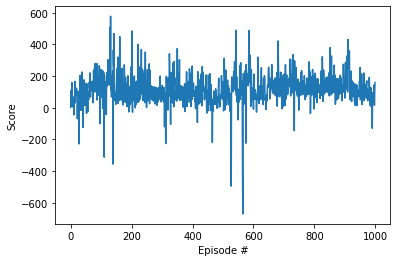

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Execute an episode with the trained agent

The following code shows an episode of the trained agent interacting with the environment at normal speed (`train_mode=False`).

In [8]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

# Create agent
agent = Agent(QNetwork, len(state), brain.vector_action_space_size, seed=42)

# Load stored parameters
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

AttributeError: 'Env' object has no attribute 'brain_names'

### 7. Video of the agent in action

In [ ]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('5kDRF2EdKRc')

In [ ]:
env.close()